#### Processamento de Big Data: Projeto Final

Licenciatura em Ciência de Dados

CDB1

Marco Delgado Esperança, Nº 110451

Maria João Ferreira Lourenço, Nº 104716

Docente: João Oliveira

8 de abril de 2023

Flight Status Prediction

https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022

# Treino e teste e implementação dos modelos SVM e K-means

Este notebook contém a criação do treino e teste e a implementação de 2 modelos - um de aprendizagem supervisionada e outro de aprendizagem não superviisionada.

In [1]:
from pyspark.shell import spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/06 20:32:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.1
      /_/

Using Python version 3.9.13 (main, Aug 25 2022 18:29:29)
Spark context Web UI available at http://marcos-mbp.home:4040
Spark context available as 'sc' (master = local[*], app id = local-1680809535299).
SparkSession available as 'spark'.


In [2]:
spark.stop()

In [3]:
from pyspark.sql import SparkSession

spark=SparkSession.builder.appName("Graficos")\
      .config("spark.driver.memory", "128g")\
      .config("spark.executor.memory", "64g")\
      .config("spark.driver.host", "127.0.0.1")\
      .getOrCreate()

In [4]:
filename = "./flights_clean.parquet"

In [5]:
df_flights_clean = spark.read.format("parquet").load(filename)

In [6]:
df_flights_clean.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = tru

In [7]:
df_sample = df_flights_clean.sample(False, 0.1, seed=42)
df_sample = df_sample.limit(15000000)

In [17]:
# Some Spark related imports we will use hereafter

import sys
import time

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Aprendizegam supervisionada

## SVM (Classificação)

Para este conjunto de dados, vamos aplicar um modelo de classificação binária por SVM (Support Vector Machine), com o objetivo de prever se um voo chegará com um atraso superior a 15 minutos (**target**: **ArrDel15**). A escolha deste target deve-se ao facto de um atraso superior a 15 minutos poder ter um grande impacto na programação e planejamento dos passageiros e das companhias aéreas, além de poder resultar em custos adicionais para ambos. Através deste modelo, é possível identificar os principais fatores que contribuem para a ocorrência de atrasos e, consequentemente, ajudar as companhias aéreas a tomar medidas preventivas para reduzir a incidência de atrasos em voos futuros.

É uma boa prática separar as variáveis numéricas das variáveis não numéricas, pois o modelo SVM pode não lida bem com variáveis não numéricas diretamente. Portanto, as variáveis não numéricas devem ser transformadas em variáveis numéricas usando técnicas como a codificação one-hot encoding ou a codificação de rótulos (label encoding) antes de serem incluídas no modelo.<br><br>

Desta forma, para iniciar o processo, este código cria duas listas de variáveis independentes, uma lista chamada *cls_numeric* e outra chamada *cls_non_numeric*. A lista *cls_numeric* contém as colunas do dataframe *df_sample* que contêm variáveis numéricas que podem ser utilizadas como recursos no modelo SVM, enquanto a lista *cls_non_numeric* contém as colunas do dataframe *df_sample* que contêm variáveis não numéricas.<br><br>

In [9]:
cls_numeric = ["CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrTime", "ArrDelayMinutes", "AirTime", "CRSElapsedTime",               
               "ActualElapsedTime", "Distance", "Quarter", "DOT_ID_Marketing_Airline", "Flight_Number_Marketing_Airline","OriginAirportID", 
               "OriginAirportSeqID", "DestAirportID", "DestAirportSeqID", "DepartureDelayGroups", "WheelsOff",  "WheelsOn", "ArrDel15", "ArrTimeBlk"]

cls_non_numeric = [i for i in df_sample.columns if i not in cls_numeric]
cls_non_numeric

['FlightDate',
 'Airline',
 'Origin',
 'Dest',
 'Cancelled',
 'Diverted',
 'DepTime',
 'Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'IATA_Code_Marketing_Airline',
 'Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Tail_Number',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestCityName',
 'DestState',
 'DestStateName',
 'DepDel15',
 'DepTimeBlk',
 'ArrDelay']

A primeira parte do código define as colunas que não são features (*cls_not_features*), ou seja, as colunas que não serão utilizadas como input para o modelo (nomeadamente o target e possíveis preditores multicolineares). Depois, são definidas as colunas categóricas e não categóricas. 

O próximo passo é codificar as colunas categóricas em índices numéricos, que podem ser usados como input para o modelo. Para isso, é usado um objeto designado StringIndexer. Em seguida, é criado um objeto OneHotEncoder que transforma os índices numéricos em vetores binários, que são mais adequados para o modelo.

Por fim, é usado um objeto VectorAssembler para juntar todas as colunas num único vetor, que será o input do modelo de classificação. As colunas de entrada são especificadas como *assembler_inputs*, que contém os nomes das colunas categóricas e não categóricas codificadas e os seus índices numéricos correspondentes. O vetor resultante é atribuído à coluna *features*.

In [10]:
# Encoding columns and vector assembling them
# See Chapter 10 of the book "Learning Spark - Lightning-Fast Data Analytics"

cls_not_features = ['FlightDate', 'ArrDelay', 'ArrDel15', 'ArrTimeBlk', "Cancelled", "Diverted"] 
categorical_cols = [i for i in cls_non_numeric if i not in cls_not_features]
non_categorical_cols = [i for i in cls_numeric if i not in cls_not_features]

index_output_cols = [x + ' Index' for x in categorical_cols]
ohe_output_cols = [x + ' OHE' for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
   
# Put all input features into a single vector, by using a transformer

assembler_inputs = ohe_output_cols + non_categorical_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
assembler_inputs

['Airline OHE',
 'Origin OHE',
 'Dest OHE',
 'DepTime OHE',
 'Year OHE',
 'Month OHE',
 'DayofMonth OHE',
 'DayOfWeek OHE',
 'Marketing_Airline_Network OHE',
 'Operated_or_Branded_Code_Share_Partners OHE',
 'IATA_Code_Marketing_Airline OHE',
 'Operating_Airline OHE',
 'IATA_Code_Operating_Airline OHE',
 'Tail_Number OHE',
 'OriginCityName OHE',
 'OriginState OHE',
 'OriginStateName OHE',
 'DestCityName OHE',
 'DestState OHE',
 'DestStateName OHE',
 'DepDel15 OHE',
 'DepTimeBlk OHE',
 'CRSDepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrTime',
 'ArrDelayMinutes',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Quarter',
 'DOT_ID_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'DestAirportID',
 'DestAirportSeqID',
 'DepartureDelayGroups',
 'WheelsOff',
 'WheelsOn']

In [11]:
categorical_cols

['Airline',
 'Origin',
 'Dest',
 'DepTime',
 'Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'IATA_Code_Marketing_Airline',
 'Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Tail_Number',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestCityName',
 'DestState',
 'DestStateName',
 'DepDel15',
 'DepTimeBlk']

In [12]:
non_categorical_cols

['CRSDepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrTime',
 'ArrDelayMinutes',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Quarter',
 'DOT_ID_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'DestAirportID',
 'DestAirportSeqID',
 'DepartureDelayGroups',
 'WheelsOff',
 'WheelsOn']

<br>
<br>

Este código divide o data set *df_sample* aleatoriamente em dois subconjuntos: um conjunto de treino (*df_train*) e um conjunto de teste (*df_test*).<br>
Usando uma seed de 42, para garantir que subamostra seja sempre a mesma, atribui-se 80% ao conjunto de treino e 20% ao conjunto de teste.

In [13]:
df_train, df_test = df_sample.randomSplit([0.8, 0.2], 42) 

<br>

Em seguida apresenta-se a contabilização do número de elementos no conjunto de treino e no conjunto de teste.

In [14]:
print(f"There are {df_train.count()} rows in the training set and {df_test.count()} in the test set.")

23/04/06 20:33:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


There are 2264861 rows in the training set and 566336 in the test set.


Tal como definido anteriormente, o modelo será treinado com a coluna *ArrDel15* como target e usará o algoritmo de otimização de gradiente descendente para minimizar a função de perda durante o treino.<br>

<br>

Os hiperparâmetros definidos são:

- maxIter: número máximo de iterações permitidas pelo algoritmo de otimização de gradiente descendente (10);
- regParam: parâmetro de regularização para evitar overfitting (ajuste excessivo) do modelo (0.1).

In [15]:
lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol='ArrDel15')

Seguidamente, criou-se um Pipeline que encapsula todo o processo de transformação e treino do modelo de classificação. O pipeline consiste em uma sequência de estados (stages), que devem ser executados em ordem.

Neste caso, a lista de estados é definida como [string_indexer, ohe_encoder, vec_assembler, lsvc].

- **string_indexer**: um transformador que mapeia colunas categóricas em índices numéricos.
- **ohe_encoder**: um transformador que transforma os índices numéricos em vetores binários (one-hot-encoding).
- **vec_assembler**: um transformador que une todos os vetores de entrada em um único vetor.
- **lsvc**: um estimador de classificação, que neste caso é um LinearSVC.

In [16]:
pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, lsvc])

Assim, criou-se um modelo de pipeline utilizando os dados de treino *df_train*.

In [18]:
start_time = time.time()
pipeline_model = pipeline.fit(df_train)
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

23/04/06 20:51:29 WARN DAGScheduler: Broadcasting large task binary with size 1358.6 KiB


23/04/06 20:53:10 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/04/06 20:53:10 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:53:59 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)
23/04/06 20:53:59 WARN BlockManager: Persisting block rdd_48_0 to disk instead.


23/04/06 20:54:59 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)
23/04/06 20:55:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/06 20:55:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/04/06 20:55:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/06 20:55:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/04/06 20:55:00 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:01 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:03 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:05 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:06 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:07 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:08 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:09 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:10 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:11 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:13 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:13 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:15 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:15 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:17 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:17 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:19 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:21 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:21 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:22 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:23 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:25 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:26 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB
23/04/06 20:55:27 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:29 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:31 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:33 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:34 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:35 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:36 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:37 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:38 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:40 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:42 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:42 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


23/04/06 20:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


23/04/06 20:55:45 WARN MemoryStore: Not enough space to cache rdd_48_0 in memory! (computed 419.1 MiB so far)


Tempo total de execução (s): 320.90149307250977 segundos
Tempo total de execução (min): 5.3483582178751625 minutos


<br>

De seguida, aplica-se o modelo treinado (pipeline_model) ao conjunto de dados de teste (*df_test*), usando o método transform() do PipelineModel. O resultado é armazenado em um novo DataFrame chamado *df_prediction*, imprimindo-se a estrutura (schema) do DataFrame resultante.

<br>

In [19]:
# Make predictions on test data and show values of columns of interest

df_prediction = pipeline_model.transform(df_test)

# Check its schema

df_prediction.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = tru

Este código mostra as colunas 'features', 'rawPrediction', 'prediction' e 'ArrDel15' do DataFrame df_prediction.

- A coluna **features** representa as características do voo (horários de partida e chegada, duração, etc.) em formato vetor. Essas características foram criadas anteriormente através do processo de codificação e vetorização.

- A coluna **rawPrediction** mostra a pontuação resultante da aplicação do modelo LinearSVC às características do voo. Essa pontuação não é a previsão final (0 ou 1), mas é uma medida da confiança do modelo na previsão.

- A coluna **prediction** mostra a previsão final (0 ou 1) do modelo LinearSVC para a coluna 'ArrDel15' (o atraso na chegada é maior ou igual a 15 minutos).

- A coluna **ArrDel15** é a variável alvo que indica se o voo teve um atraso na chegada maior ou igual a 15 minutos (1) ou não (0).

In [20]:
# Columns to be focus on

df_prediction.select('features', 'rawPrediction', 'prediction', 'ArrDel15').show() 

23/04/06 20:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1450.8 KiB


+--------------------+--------------------+----------+--------+
|            features|       rawPrediction|prediction|ArrDel15|
+--------------------+--------------------+----------+--------+
|(10412,[17,194,41...|[0.80052559210690...|       0.0|     0.0|
|(10412,[17,50,454...|[1.21949266390181...|       0.0|     0.0|
|(10412,[17,28,537...|[1.08230908707386...|       0.0|     0.0|
|(10412,[17,28,566...|[-3.3058396577280...|       1.0|     1.0|
|(10412,[10,37,442...|[-1.2519736322716...|       1.0|     1.0|
|(10412,[10,234,66...|[-0.4391781912607...|       1.0|     1.0|
|(10412,[10,65,442...|[1.29848166000987...|       0.0|     0.0|
|(10412,[10,56,429...|[1.14829699988868...|       0.0|     0.0|
|(10412,[10,33,483...|[0.98596471388529...|       0.0|     0.0|
|(10412,[10,33,483...|[1.15681808060158...|       0.0|     0.0|
|(10412,[10,33,483...|[1.11290939295176...|       0.0|     0.0|
|(10412,[10,33,429...|[1.03681530851206...|       0.0|     1.0|
|(10412,[10,33,481...|[1.17433940888603.

### Avaliação dos resultados

Em primeiro lugar, procedeu-se ao cálculo da métrica de avaliação binária "areaUnderROC" (Área sob a curva ROC), que é uma medida da qualidade do modelo para classificar corretamente exemplos positivos e negativos. Para isso, são usados os dados de teste que foram processados pelo pipeline de treinamento e ajustados pelo modelo treinado.

In [21]:
# Compute evaluation metrics on test data

prediction_label = df_prediction.select('rawPrediction', 'prediction', 'ArrDel15')  

# supports metricName="areaUnderROC" (default) and "areaUnderPR"
# it relates to sensitivity (TP rate) and specificity (FP rate)

evaluator = BinaryClassificationEvaluator(labelCol='ArrDel15')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))
# print("areaUnderPR = " + str(evaluator.evaluate(prediction_label, {evaluator.metricName: 'areaUnderPR'})))

23/04/06 20:58:40 WARN DAGScheduler: Broadcasting large task binary with size 1447.3 KiB


areaUnderROC = 0.977832125303426


No contexto deste modelo, uma área sob a curva ROC de 0.9778 indica que o modelo é capaz de distinguir entre voos que chegam com atraso de pelo menos 15 minutos e voos que chegam na hora ou com um atraso menor com uma precisão muito alta.

<br>

Em seguida, para o cálculo de diversas métricas de classificação, procedeu-se ao cálculo da contagem de cada caso do resultado da previsão feita pelo modelo SVM no conjunto de teste. 

In [22]:
# Counting rows for each case TP, TN, FP and FN respectively

n = df_prediction.count()
tp = df_prediction.filter((F.col('prediction') > 0) & (F.col('ArrDel15') == 1)).count()
tn = df_prediction.filter((F.col('prediction') == 0) & (F.col('ArrDel15') == 0)).count()
fp = df_prediction.filter((F.col('prediction') > 0) & (F.col('ArrDel15') == 0)).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]

23/04/06 21:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1454.5 KiB


23/04/06 21:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1454.3 KiB


23/04/06 21:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1454.5 KiB


[77704, 446723, 19617, 22290, 566334]

In [23]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.9260030300140907

No contexto deste modelo, uma accuracy de 0.926 significa que o modelo acertou 92.6% das vezes na sua previsão de atrasos de voo de pelo menos 15 minutos.

In [24]:
precision = tp / (tp + fp)
precision

0.7984299380400941

A precision de 0.7984 significa que, das vezes em que o modelo previu que um voo seria atrasado em pelo menos 15 minutos (ou seja, classificou como positivo), em média, 79.84% desses voos realmente foram atrasados.

In [25]:
recall = tp / (tp + fn)
recall

0.7770866251975118

Um recall de 0.777 significa que o modelo foi capaz de identificar corretamente 77.7% de todos os voos que realmente atrasaram pelo menos 15 minutos (classe positiva).

In [26]:
specificity = tn / (tn + fp)
specificity

0.9579341253162929

No contexto do modelo, uma specificity de 0.9579 significa que 95.79% dos voos que não tiveram atrasos superiores a 15 minutos foram corretamente identificados como não tendo atrasos significativos pelo modelo.

In [27]:
f1_score = 2 * recall * precision / (recall + precision)
f1_score

0.7876137141119529

No que diz respeito ao F1-score, que é de 0.7876, significa que o modelo é razoavelmente preciso na detecção de voos atrasados pelo menos 15 minutos (classe positiva) e não atrasados (classe negativa). 

# Aprendizagem não supervisionada 

## KMeans

No contexto de dados de atrasos em voos, o modelo KMeans, um dos algoritmos mais populares de aprendizagem não supervisionada, pode ser usado como uma ferramenta de aprendizagem não supervisionada para descobrir padrões e agrupamentos entre os voos com atrasos. Esses padrões podem ajudar as companhias aéreas e os reguladores a entender melhor as causas dos atrasos e a tomar medidas para melhorar o desempenho e a eficácia do sistema de transporte aéreo. O modelo KMeans é especialmente adequado para esse tipo de análise, pois é capaz de agrupar dados em clusters com base nas suas características semelhantes, o que pode ser útil para detectar padrões ocultos e relacionamentos entre os voos com atrasos.

In [28]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation

<br>

### Padrões de atraso entre atrasos de partida/chegada e distância

Em primeiro lugar, procedeu-se à seleção de três colunas específicas (*DepDelay*, *ArrDelay* e *Distance*) do DataFrame *df_sample*. As colunas selecionadas são usadas para ajustar um modelo de clustering K-means.

In [29]:
cols = ["DepDelay", "ArrDelay", "Distance"]

De seguida, criou-se uma instância do VectorAssembler, que é um transformador que combina várias colunas em uma única coluna de recursos (features).
Recorreu-se ao método "transform()" do VectorAssembler para aplicar a transformação aos dados em *df_sample*. O parâmetro *inputCols* especifica as colunas de entrada que serão usadas para criar a nova coluna de recursos (features), enquanto o parâmetro *outputCol* especifica o nome da nova coluna criada.

In [30]:
# Criação do vector

vec_assembler = VectorAssembler(inputCols=cols, outputCol="features")
vec_df = vec_assembler.transform(df_sample)

In [31]:
# Imprimir as colunas do vetor

vec_df.columns

['FlightDate',
 'Airline',
 'Origin',
 'Dest',
 'Cancelled',
 'Diverted',
 'CRSDepTime',
 'DepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrTime',
 'ArrDelayMinutes',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Marketing_Airline_Network',
 'Operated_or_Branded_Code_Share_Partners',
 'DOT_ID_Marketing_Airline',
 'IATA_Code_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'Operating_Airline',
 'IATA_Code_Operating_Airline',
 'Tail_Number',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityName',
 'DestState',
 'DestStateName',
 'DepDel15',
 'DepartureDelayGroups',
 'DepTimeBlk',
 'WheelsOff',
 'WheelsOn',
 'ArrDelay',
 'ArrDel15',
 'ArrTimeBlk',
 'features']

<br>

De forma a escolhermos o melhor k (número de clusters) para a aplicação do algoritmo KMeans, decidimos reduzir o tamanho do vetor usado para treinar o modelo, limitando o número de linhas do DataFrame da amostra para 100 (*max_tiny*). <br>

Definido esse limite, após a criação do DataFrame *vec_dftiny* limitado com o número de linhas anteriormente indicado, aplicou-se o VectorAssembler que combina as colunas especificadas em *cols* em uma única coluna de features, que é adicionada como uma nova coluna no DataFrame resultante.

In [32]:
# para encontrar o melhor k iremos reduzir o tamanho do nosso vetor
max_tiny = 100
vec_dftiny = vec_assembler.transform(df_sample.limit(max_tiny))

<br>

Criou-se uma instância do modelo K-means com o número de clusters definido por "k", semente (seed) igual a 221 e número máximo de iterações igual a 20.
Ajustou-se o modelo aos dados de treino (*vec_dftiny*) usando o método "fit()", sendo o modelo é usado para gerar previsões para os dados de treino usando o método "transform()".<br>
Os centroides são armazenados numa lista designada *cluster_centres*.
Por fim, calcula-se a métrica de Silhouette para as previsões geradas pelo modelo, usando o objeto *evaluator*, sendo o valor armazenado na lista *silhouettes*.
O código fornece uma lista de valores de Silhouette para cada valor de "k" testado. Isso pode ser usado para selecionar o número ideal de clusters para o modelo de KMeans, ou seja, aquele que maximiza a métrica de Silhouette.

In [33]:
# Algortimo K-Means
from pyspark.ml.evaluation import ClusteringEvaluator

start_time = time.time()
evaluator = ClusteringEvaluator()

silhouettes = []
cluster_centres = []
for k in range(2,20):
    
    # Treina um modelo K-mean
    kmeans = KMeans(k=k, seed=221, maxIter=20)
    
    # Ajuste do modelo
    model = kmeans.fit(vec_dftiny)
    
    # usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
    predictions = model.transform(vec_dftiny)
    

    # Obter ClustersCenters através do modelo
    cluster_centres.append(model.clusterCenters())
    
    # Avaliação do modelo com base no silhouette
    silhouettes.append(evaluator.evaluate(predictions))
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

Tempo total de execução (s): 22.267162084579468 segundos
Tempo total de execução (min): 0.37111936807632445 minutos


De seguida, imprime-se os resultados dos centroides dos clusters e das métricas de Silhouette para cada valor de k testado no modelo de clustering KMeans.

In [34]:
# Resultados dos clusterscenters e silhouette

print("Cluster centres: ")
for centroid in cluster_centres:
    print(centroid)
print("Silhouettes with squared euclidean distances: ")
print(silhouettes)

Cluster centres: 
[array([  5.87096774,  -0.77419355, 307.72580645]), array([  4.23684211,  -6.02631579, 616.        ])]
[array([ 6.23333333e+00, -1.16666667e-01,  3.03050000e+02]), array([  4.05405405,  -6.91891892, 569.27027027]), array([ 3.33333333e-01, -4.66666667e+00,  1.08033333e+03])]
[array([ -4.14285714, -19.71428571, 904.        ]), array([  4.0625,  -0.4375, 140.125 ]), array([  6.12903226,  -2.93548387, 550.96774194]), array([  6.5       ,  -0.89130435, 366.02173913])]
[array([  6.12903226,  -2.93548387, 550.96774194]), array([  4.0625,  -0.4375, 140.125 ]), array([  6.5       ,  -0.89130435, 366.02173913]), array([ -6.8, -24.4, 795. ]), array([   2.5,   -8. , 1176.5])]
[array([  1.33333333,  -9.        , 552.66666667]), array([  4.0625,  -0.4375, 140.125 ]), array([ 2.58064516e-01, -9.51612903e+00,  3.42193548e+02]), array([ -6.8, -24.4, 795. ]), array([   2.5,   -8. , 1176.5]), array([ 27.5625,  27.0625, 420.5625])]
[array([  4.0625,  -0.4375, 140.125 ]), array([9.2352941

<br>

Em seguida, procedou-se à apresentação de um gráfico que mostra como a métrica de Silhouette varia com o número de clusters em um modelo de clustering KMeans. Procurou-se o número ideal de clusters, que é aquele que maximiza a métrica de Silhouette, ou seja, aquele que corresponde ao valor mais alto do eixo y no gráfico.

Text(0, 0.5, 'silhouette score')

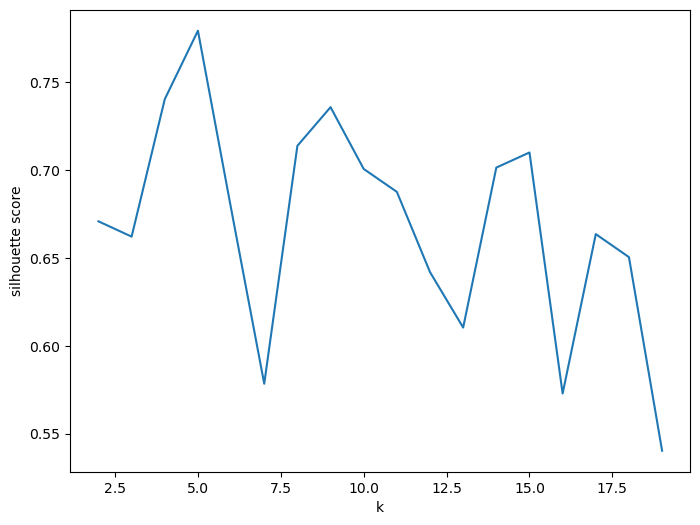

In [35]:
# Escolher melhor k
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouettes[0:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')

O pico mais alto é atingido para k=5, então escolhe-se esse valor para k.

In [36]:
optimal_k = 5

<br>

Aplica-se o modelo KMeans, usando o valor ótimo determinado para k (5).
O modelo KKMeans é inicializado com o número de clusters ótimo encontrado anteriormente (*optimal_k*=5), um valor de semente aleatório fixo (*seed*=221) e um limite máximo de iterações (*maxIter*=20).<br>
Ajusta-se  o modelo aos dados de treino usando o método "fit()" com o conjunto de dados que passou pelo processo de transformação com VectorAssembler (*vec_df*).<br> 
O modelo é então usado para prever os clusters para todo o conjunto de dados com o método "transform()".<br>
Usa-se o método "clusterCenters()" para obter os centroides dos clusters do modelo, usando a métrica de Silhouette para avaliar o desempenho do modelo.<br>
Finalmente, imprimem-se os centroides dos clusters.

<br>

In [37]:
# Avaliar o modelo com optimal_k = 5

# Algoritmo K-means aplicado a todo o dataset (sem vec_dftiny)
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

start_time = time.time()
# Loads data
dataset = df_sample

# Treina um modelo K-mean
kmeans = KMeans(k=optimal_k, seed=221, maxIter=20)

# Ajuste do modelo
model = kmeans.fit(vec_df)

# usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
predictions = model.transform(vec_df)
    
# Obter ClustersCenters através do modelo
cluster_centres = model.clusterCenters()

# Avaliar o clustering calculando o valor do Silhouette
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Mostrar os resultados
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)
    
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

Silhouette with squared euclidean distance = 0.6980553448359867
Cluster Centers: 
[  9.29277053   3.91349379 613.83473151]
[  8.072814     3.34661518 277.08166936]
[9.83938256e+00 1.13501627e+00 2.45359735e+03]
[  10.17033023    2.63316883 1607.00594719]
[  10.38634541    4.53472864 1015.45989227]
Tempo total de execução (s): 53.2317750453949 segundos
Tempo total de execução (min): 0.8871962507565816 minutos


Com todas as variaveis e K=5, Silhouette with squared euclidean distance = 0.698, logo o modelo tem uma coesão média com os dados iniciais.

<br>

De seguida, apresenta-se o número dos diferentes clusters.

In [40]:
# Mostrar os números dos diferentes clusteres

predictions.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|         1|
|         0|
|         4|
|         2|
|         3|
+----------+



## Gráfico de dispersão para a relação entre o atrasa na partida (DepDelay) e o atraso na chegada (ArrDelay)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/3442062530.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,1], s=40, cmap='viridis');


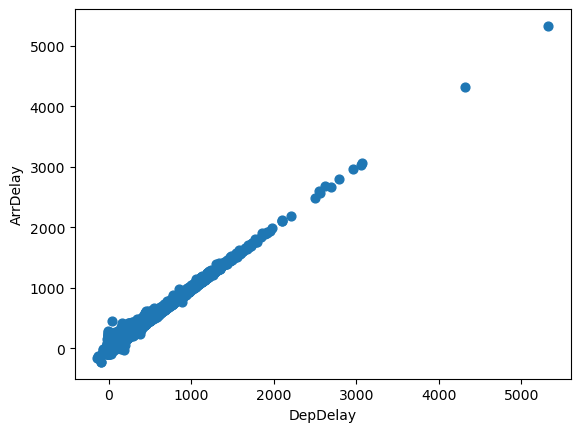

In [57]:
# Vizualização do algoritmo K Means
import matplotlib.pyplot as plt 
import pandas
import numpy as np

df_plot =  predictions.select(["DepDelay", "ArrDelay", "Distance"]).toPandas()
plt.xlabel('DepDelay')
plt.ylabel('ArrDelay')
plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,1], s=40, cmap='viridis');

Verifica-se que há uma relação, tal como se esperava, diretamente proporcinal entre o atrado de partida (*DepDelay*) e atraso de chegada (*ArrDelay*).

## Gráfico de dispersão para a relação entre o atraso na partida (DepDelay) e a distância entre os aeroportos (Distance)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/1811034646.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,2], s=20, cmap='viridis');


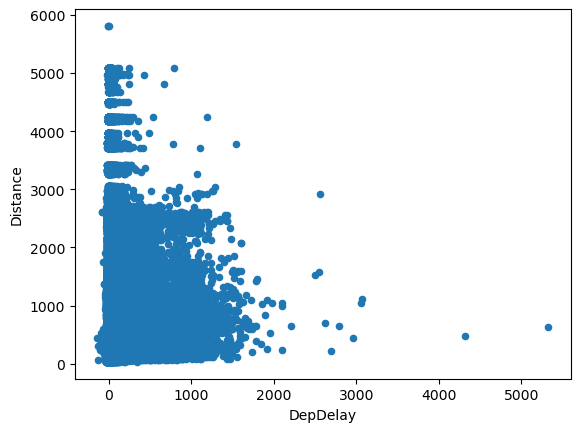

In [58]:
df_plot =  predictions.select(["DepDelay", "ArrDelay", "Distance"]).toPandas()
plt.xlabel('DepDelay')
plt.ylabel('Distance')
plt.scatter(df_plot.iloc[:,0], df_plot.iloc[:,2], s=20, cmap='viridis');

Neste gráfico podemos observar que há uma tendência para quanto maior for a distância da viagem, menor serem os atrasos nas partidas. Além disso, verifica-se que a maioria dos atrasos não é muito significativo, até porque a viagem mais longa tem um atraso nulo.

## Gráfico de dispersão para a relação entre o atraso na chegada (ArrDelay) e a distância entre aeroportos (Distance)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/3671868252.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,2], s=20, cmap='viridis');


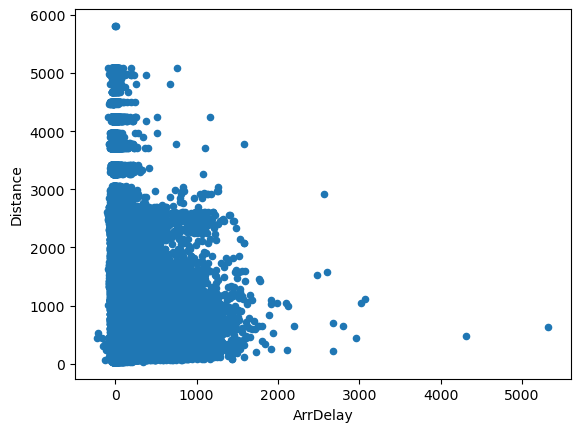

In [52]:
df_plot =  predictions.select(["DepDelay", "ArrDelay", "Distance"]).toPandas()
plt.xlabel('ArrDelay')
plt.ylabel('Distance')
plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,2], s=20, cmap='viridis');

De forma idêntica à análise anterior, verifica-se que há uma tendência para quanto maior for a distância na viagem, menor serem os atrasos nas chegadas.

## Identificar padrões de atraso baseado em outros fatores

De forma a identificar padrões de atraso baseados em outros fatores escolheram-se as colunas que se apresentam abaixo para aplicar o KMeans.

In [40]:
cols2 = ["Airline", "Origin", "Dest", "CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month"]

<br>

Primeiro, são criados indexadores de string para as colunas "Airline", "Origin" e "Dest". O resultado desse processo é uma nova coluna para cada coluna original, com o sufixo "_index", contendo os valores numéricos correspondentes a cada categoria.

Em seguida, é utilizado o encoder OneHotEncoder para converter as colunas indexadas em vetores binários, onde cada elemento do vetor representa uma categoria da variável. Assim, para cada categoria, é criado um novo atributo, onde o valor 1 indica que aquela categoria está presente na observação e o valor 0 indica ausência.

As colunas selecionadas para compor o vetor de características são: "CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month", "Airline_vec", "Origin_vec" e "Dest_vec". É utilizado o VectorAssembler para juntar essas colunas em um único vetor, com o nome "features", que será utilizado no treino do modelo. O método "limit(100)" é utilizado para limitar o número de observações do dataset para 100, apenas para fins de demonstração.

<br>

In [41]:
# Criação do vector
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep")
            for col in ["Airline", "Origin", "Dest"]]
indexed = Pipeline(stages=indexers).fit(df_sample).transform(df_sample)


encoder = OneHotEncoder(inputCols=["Airline_index", "Origin_index", "Dest_index"], outputCols=["Airline_vec", "Origin_vec", "Dest_vec"])
encoded = encoder.fit(indexed).transform(indexed)


cols2 = ["CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month", "Airline_vec", "Origin_vec", "Dest_vec"]
assembler = VectorAssembler(inputCols=cols2, outputCol="features")
assembled = assembler.transform(encoded.limit(100))

De forma análoga à explicada anteriormente, calcula-se o Silhouette score para diferentes valores de k.

In [42]:
# Algortimo K-Means
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

start_time = time.time()
evaluator = ClusteringEvaluator()

silhouettes = []
cluster_centres = []
for k in range(2,20):
    
    # Treina um modelo K-mean
    kmeans = KMeans(k=k, seed=221, maxIter=20)
    
    # Ajuste do modelo
    model = kmeans.fit(assembled)
    
    # usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
    prediction = model.transform(assembled)
    

    # Obter ClustersCenters através do modelo
    cluster_centres.append(model.clusterCenters())
    
    # Avaliação do modelo com base no silhouette
    silhouettes.append(evaluator.evaluate(prediction))
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

Tempo total de execução (s): 148.84939885139465 segundos
Tempo total de execução (min): 2.480823314189911 minutos


Em seguida apresenta-se o gráfico na procura do pico mais alto que é encontrado para k=2.

Text(0, 0.5, 'silhouette score')

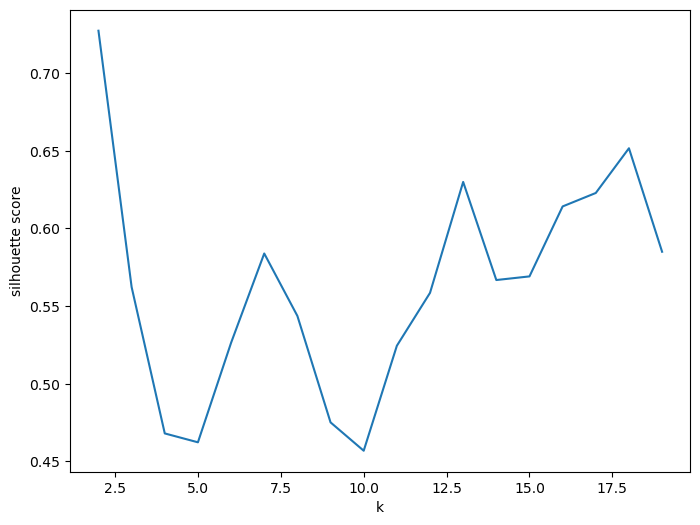

In [43]:
# Escolher melhor k
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouettes[0:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette score')

Escolhe-se o valor ótimo segundo a Silhouette score para k (k=2).

In [44]:
optimal_k = 2

Em seguida avalia-se o modelo com k=2 e calcula-se o centroide para cada cluster.

In [45]:
#Avaliar o modelo com optimal_k = 2

# Algoritmo K-means aplicado a todo o dataset (sem vec_dftiny)
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

start_time = time.time()
# Loads data
dataset = df_sample

# Treina um modelo K-mean
kmeans = KMeans(k=optimal_k, seed=221, maxIter=20)

# Ajuste do modelo
model = kmeans.fit(assembled)

# usar modelo para transformar o DataFrame ao adicionar previsões com aglomerados ("cluster") 
predictions = model.transform(assembled)
    
# Obter ClustersCenters através do modelo
cluster_centres = model.clusterCenters()

# Avaliar o clustering calculando o valor do Silhouette
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Mostrar os resultados
print("Cluster Centers: ")
ctr=[]
centers = model.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)
    
end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time/60
print("Tempo total de execução (s):", elapsed_time, "segundos")
print("Tempo total de execução (min):", elapsed_time_min, "minutos")

Silhouette with squared euclidean distance = 0.7273011247796886
Cluster Centers: 
[ 8.29869565e+02  4.56521739e+00 -8.91304348e-01  3.47826087e+00
  6.60434783e+01  3.96804348e+02  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.69565217e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.17391304e-02  0.00000000e+00
  0.00000000e+00  2.17391304e-02  0.00000000e+00  2.17391304e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0000

- Com todas as variaveis e K=2, Silhouette com dist squared euclidean distance = 0.73, logo o modelo tem uma coesão moderada com os dados iniciais

<br>

Em seguida, apresentam-se as "previsões" do algoritmo de clustering.

In [65]:
predictions.toPandas()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,...,ArrDel15,ArrTimeBlk,Airline_index,Origin_index,Dest_index,Airline_vec,Origin_vec,Dest_vec,features,prediction
0,2018-01-05,Endeavor Air Inc.,ATL,ABY,False,False,1037,1032.0,0.0,-5.0,...,0.0,1100-1159,8.0,0.0,271.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1037.0, 0.0, -5.0, 0.0, 29.0, 145.0, 1.0, 0.0...",0
1,2018-01-13,Endeavor Air Inc.,ATL,ABY,False,False,1037,1034.0,0.0,-3.0,...,0.0,1100-1159,8.0,0.0,271.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1037.0, 0.0, -3.0, 0.0, 34.0, 145.0, 1.0, 0.0...",0
2,2018-01-15,Endeavor Air Inc.,ATL,ABY,False,False,1037,1030.0,0.0,-7.0,...,0.0,1100-1159,8.0,0.0,271.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1037.0, 0.0, -7.0, 0.0, 30.0, 145.0, 1.0, 0.0...",0
3,2018-01-23,Endeavor Air Inc.,ATL,ABY,False,False,1037,1032.0,0.0,-5.0,...,0.0,1100-1159,8.0,0.0,271.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1037.0, 0.0, -5.0, 0.0, 38.0, 145.0, 1.0, 0.0...",0
4,2018-01-28,Endeavor Air Inc.,ATL,ABY,False,False,1037,1052.0,15.0,15.0,...,0.0,1100-1159,8.0,0.0,271.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1037.0, 15.0, 15.0, 0.0, 30.0, 145.0, 1.0, 0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2018-01-09,Endeavor Air Inc.,ATL,PIA,False,False,1458,1453.0,0.0,-5.0,...,0.0,1500-1559,8.0,0.0,161.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1458.0, 0.0, -5.0, 0.0, 92.0, 565.0, 1.0, 0.0...",1
96,2018-01-22,Endeavor Air Inc.,ATL,PIA,False,False,1458,1449.0,0.0,-9.0,...,0.0,1500-1559,8.0,0.0,161.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1458.0, 0.0, -9.0, 0.0, 87.0, 565.0, 1.0, 0.0...",1
97,2018-01-25,Endeavor Air Inc.,ATL,PIA,False,False,1458,1455.0,0.0,-3.0,...,0.0,1500-1559,8.0,0.0,161.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1458.0, 0.0, -3.0, 0.0, 92.0, 565.0, 1.0, 0.0...",1
98,2018-01-26,Endeavor Air Inc.,ATL,PIA,False,False,1458,1452.0,0.0,-6.0,...,0.0,1500-1559,8.0,0.0,161.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1458.0, 0.0, -6.0, 0.0, 84.0, 565.0, 1.0, 0.0...",1


<br>

Seguidamente, apresentam-se o número dos diferentes clusters.

In [66]:
# Mostrar os números dos diferentes clusteres
predictions.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|         0|
|         1|
+----------+



In [67]:
# Relembrar as colunas selecionadas

cols2 = ["Airline", "Origin", "Dest", "CRSDepTime", "DepDelayMinutes", "DepDelay", "ArrDelayMinutes", "AirTime", "Distance", "Month"]

## Gráfico de dispersão para a relação entre a Origem (Origin) e atraso na partida (DestDelay)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/2158272528.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,5], s=40, cmap='viridis');


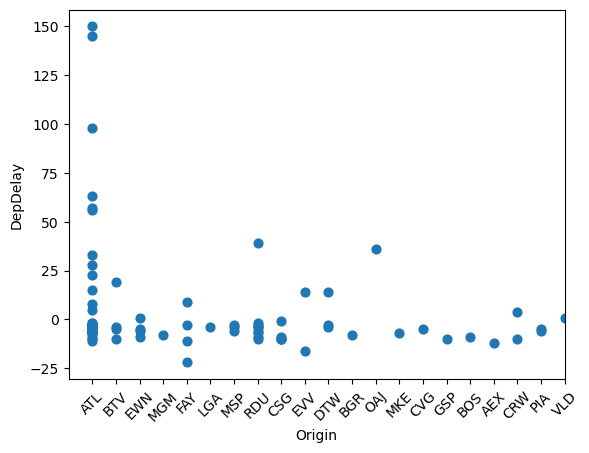

In [69]:
# Visualização do algoritmo Kmeans

df_plot =  predictions.select(cols2).toPandas()
plt.xlim(-1,20)
plt.xticks(rotation=45)
plt.xlabel(cols2[1])
plt.ylabel(cols2[5])
plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,5], s=40, cmap='viridis');

Pela análise deste gráfico, verificamos que existe um claro destaque com partidas atrasadas para o aeroporto de Atlanta (ATL).

## Gráfico de dispersão para a relação entre o Destino (Dest) e atraso na partida (DestDelay)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/3408388266.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,2], df_plot.iloc[:,5], s=40, cmap='viridis');


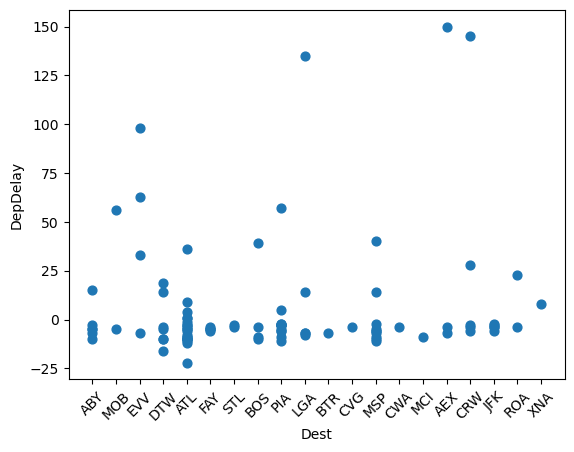

In [79]:
# # Visualização do algoritmo Kmeans

df_plot =  predictions.select(cols2).toPandas()
plt.xlim(-1,20)
plt.xticks(rotation=45)
plt.xlabel(cols2[2])
plt.ylabel(cols2[5])
plt.scatter(df_plot.iloc[:,2], df_plot.iloc[:,5], s=40, cmap='viridis');

Há uma tendência para os voos partirem a tempo ou até adiantados, havendo contudo alguns exemplos de voos com grande atrasos de partida.

## Gráfico de dispersão para a relação entre a origem (Origin) e o atraso de chegada em minutos (ArrDelayMinutes)

/var/folders/6f/xxdlxkl953v7h6b6nsn7dhp40000gn/T/ipykernel_21615/2496826933.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,6], s=40, cmap='viridis');


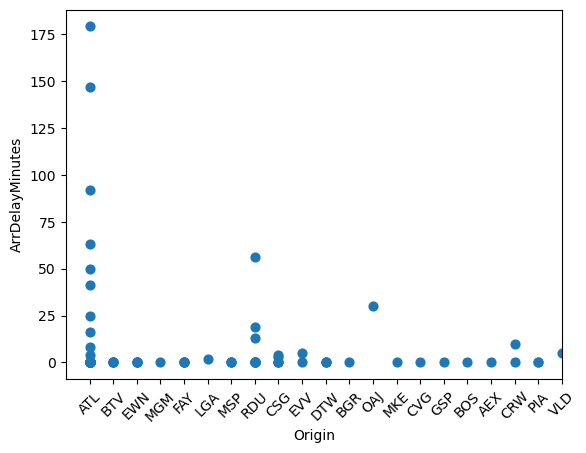

In [72]:
# Visualização do algoritmo Kmeans

df_plot =  predictions.select(cols2).toPandas()
plt.xlim(-1,20)
plt.xticks(rotation=45)
plt.xlabel(cols2[1])
plt.ylabel(cols2[6])
plt.scatter(df_plot.iloc[:,1], df_plot.iloc[:,6], s=40, cmap='viridis');

Constata-se que tal como nos atrasos das partidas, é o aeroporto de Atlanta (ATL) que regista os maiores atrasos de chegada (em minutos).